# Introduction

In this notebook we demonstrate the use of LSI (Latent Semantic Indexing) Information Retrieval technique to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix

## Load Data

In [2]:
trace_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/trace_matrix.csv')
trace_df.head()

,src_artf,trg_artf,link
0,BR_4020_SRC,UC_003_TRG,0
1,BR_4020_SRC,UC_007_TRG,0
2,BR_4020_SRC,UC_010_TRG,0
3,BR_4020_SRC,UC_002_TRG,0
4,BR_4020_SRC,UC_006_TRG,1


In [3]:
trace_df.shape

(140, 3)

In [4]:
artfs_desc_df = pd.read_csv('../data/jEdit/jEditDataset/oracle/output/artifacts_descriptions.csv', sep="|")
artfs_desc_df.head(50)

,artf_name,artf_description
0,BR_4020_SRC,Bug Number: 4020\nSummary: XML with entity and...
1,BR_3890_SRC,Bug Number: 3890\nSummary: HTML/XHTML DTD and ...
2,BR_3844_SRC,"Bug Number: 3844\nSummary: edit - ""indent line..."
3,BR_4065_SRC,Bug Number: 4065\nSummary: Ruby syntax highlig...
4,BR_3880_SRC,Bug Number: 3880\nSummary: Syntax Highlighting...
5,BR_3987_SRC,Bug Number: 3987\nSummary: multiview doesn't s...
6,BR_4067_SRC,Bug Number: 4067\nSummary: Erroneous Dialog - ...
7,BR_3973_SRC,Bug Number: 3973\nSummary: file browser (save ...
8,BR_3898_SRC,Bug Number: 3898\nSummary: Bracket matching no...
9,BR_3908_SRC,Bug Number: 3908\nSummary: Performance problem...


In [5]:
artfs_desc_df.shape

(24, 2)

## Data Preprocessing

In [6]:
use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
use_cases_df.head()

,artf_name,artf_description
14,UC_003_TRG,Use Case ID: 003\n\nUse Case Name: User Replac...
15,UC_007_TRG,Use Case ID: 007\n\nUse Case Name: User Create...
16,UC_010_TRG,Use Case ID: 010\n\nUse Case Name: User Indent...
17,UC_002_TRG,Use Case ID: 002\n\nUse Case Name: User Saves ...
18,UC_006_TRG,Use Case ID: 006\n\nUse Case Name: User Opens ...


In [7]:
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]
bug_reports_df.head()

,artf_name,artf_description
0,BR_4020_SRC,Bug Number: 4020\nSummary: XML with entity and...
1,BR_3890_SRC,Bug Number: 3890\nSummary: HTML/XHTML DTD and ...
2,BR_3844_SRC,"Bug Number: 3844\nSummary: edit - ""indent line..."
3,BR_4065_SRC,Bug Number: 4065\nSummary: Ruby syntax highlig...
4,BR_3880_SRC,Bug Number: 3880\nSummary: Syntax Highlighting...


## Vectorize Corpus

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import LancasterStemmer

class Tokenizer(object):
    
    def __init__(self):
        self.tok = RegexpTokenizer(r'some_regular_expression')
        self.stemmer = LancasterStemmer()
    
    def __call__(self, doc):
        return [self.stemmer.stem(token) 
                for token in self.tok.tokenize(doc)]

vectorizer = TfidfVectorizer(stop_words='english',
                         use_idf=True, 
                         smooth_idf=True)

## SVD Transformation 

In [9]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=100, 
                         algorithm='randomized',
                         n_iter=10, random_state=42)

## Pipeline

In [10]:
from sklearn.pipeline import Pipeline

corpus = use_cases_df.artf_description

svd_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model)])

svd_matrix = svd_transformer.fit_transform(corpus)

## Vectorize Query Corpus

In [11]:
query = bug_reports_df.artf_description
query_vector = svd_transformer.transform(query)

In [12]:
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(query_vector, 
                                     svd_matrix, 
                                     metric='cosine', 
                                     n_jobs=-1)

print(distance_matrix)

[[0.76183964 0.7871869  0.72662206 0.47823843 0.34470983 0.52026444
  0.18138903 0.39168294 0.92719236 0.91594131]
 [0.68498706 0.79615296 0.93980893 0.60134476 0.11905584 0.48900347
  0.23374624 1.         0.87580531 0.94693116]
 [0.92158677 0.86154235 0.10214744 1.         1.         1.
  1.         1.         0.89832965 0.84830335]
 [1.         1.         1.         1.         1.         1.
  1.         0.07083447 1.         1.        ]
 [0.91314687 0.95532915 0.80962194 0.69499955 0.80347947 0.75192453
  0.76485122 0.07337884 1.         0.83214881]
 [0.33601348 0.28351503 0.43341649 0.35670147 0.48119098 0.33466231
  0.30161511 0.50176853 0.28256427 0.50045862]
 [0.6844322  0.82088593 0.92032059 0.47227033 0.24144784 0.39040097
  0.07710424 0.58717574 0.80271307 0.92974882]
 [0.72258799 0.84314836 0.95127178 0.24766047 0.59842502 0.25274634
  0.45942748 0.95000868 0.95680856 0.95703764]
 [0.9869092  0.99406217 0.93467474 0.9790062  0.96036463 0.96702478
  0.95055273 0.91788645 0.99

## Recovering Rank of Documents

In [13]:
trace_results_df = pd.DataFrame(use_cases_df.artf_name)

bug_reports_list = bug_reports_df.artf_name

for i in range(0, len(list(distance_matrix))):
    trace_results_df[bug_reports_list[i]] = distance_matrix[i]
    
trace_results_df.head(20)

,artf_name,BR_4020_SRC,BR_3890_SRC,BR_3844_SRC,BR_4065_SRC,BR_3880_SRC,BR_3987_SRC,BR_4067_SRC,BR_3973_SRC,BR_3898_SRC,BR_3908_SRC,BR_4058_SRC,BR_4018_SRC,BR_4005_SRC,BR_3974_SRC
14,UC_003_TRG,0.761840,0.684987,0.921587,1.000000,0.913147,0.336013,0.684432,0.722588,0.986909,0.990088,0.925016,0.725336,0.890822,1.0
15,UC_007_TRG,0.787187,0.796153,0.861542,1.000000,0.955329,0.283515,0.820886,0.843148,0.994062,0.990946,0.133225,0.886930,0.995557,1.0
16,UC_010_TRG,0.726622,0.939809,0.102147,1.000000,0.809622,0.433416,0.920321,0.951272,0.934675,0.595291,0.963437,0.911588,0.931380,1.0
17,UC_002_TRG,0.478238,0.601345,1.000000,1.000000,0.695000,0.356701,0.472270,0.247660,0.979006,0.967989,0.757840,0.426831,0.939927,1.0
18,UC_006_TRG,0.344710,0.119056,1.000000,1.000000,0.803479,0.481191,0.241448,0.598425,0.960365,0.960169,0.698684,0.234335,0.910288,1.0
19,UC_004_TRG,0.520264,0.489003,1.000000,1.000000,0.751925,0.334662,0.390401,0.252746,0.967025,0.968217,0.759562,0.450151,0.839183,1.0
20,UC_005_TRG,0.181389,0.233746,1.000000,1.000000,0.764851,0.301615,0.077104,0.459427,0.950553,0.952340,0.639457,0.064591,0.886041,1.0
21,UC_008_TRG,0.391683,1.000000,1.000000,0.070834,0.073379,0.501769,0.587176,0.950009,0.917886,0.874795,1.000000,0.744001,0.056427,1.0
22,UC_001_TRG,0.927192,0.875805,0.898330,1.000000,1.000000,0.282564,0.802713,0.956809,0.991455,1.000000,1.000000,0.849412,0.828739,1.0
23,UC_009_TRG,0.915941,0.946931,0.848303,1.000000,0.832149,0.500459,0.929749,0.957038,0.095587,0.087244,0.967764,0.926950,0.990265,1.0


In [20]:
cols = trace_results_df.columns.delete(0)  # artf_name
artf_names = trace_results_df.artf_name

In [21]:
def recover_trace_links_df(threshold):
    aux_df = trace_results_df.copy()
    aux_df.set_index('artf_name', inplace=True)
    
    amount_target_docs = use_cases_df.shape[0]
    
    for col in cols:
        nlargest_df = trace_results_df.nlargest(n = int(threshold * amount_target_docs), columns=col, keep='first')    
        aux_df[col] = [1 if x in nlargest_df[col].tolist() else 0 for x in aux_df[col]]

    return aux_df

## Evaluate Recovering Efficiency

In order to evaluate the efficiency of the algorithm tested (LSI), we use common metrics applied to the field of IR:

    * Precision
    * Recall
    * F1-score

### Matrices Transformations

First, we need to make that the **oracle traces matrix** and **recovered traces matrix** have the same format:

In [22]:
def load_oracle():
    oracle_trace_df = pd.DataFrame(columns=cols)
    oracle_trace_df.insert(0, 'artf_name', list(artf_names))
    oracle_trace_df.head(20)

    for index, row in trace_df.iterrows():
        idx = oracle_trace_df[oracle_trace_df.artf_name == row['trg_artf']].index
        oracle_trace_df.at[idx, row['src_artf']] = row['link']
    
    oracle_trace_df.set_index('artf_name', inplace=True)
    
    return oracle_trace_df

### Create Evaluation Dataframe

In [23]:
def evaluate_model(oracle_df, recovered_df):
    y_true = csr_matrix(oracle_df.values, dtype=int)
    y_pred = csr_matrix(recovered_df.values, dtype=int)

    p, r, f, sp = precision_recall_fscore_support(y_true, y_pred)

    eval_df = pd.DataFrame(columns=['precision','recall','fscore'])

    i = 0
    for idx, row in oracle_trace_df.iteritems():
        eval_df.at[idx, 'precision'] = p[i]
        eval_df.at[idx, 'recall'] = r[i]
        eval_df.at[idx, 'fscore'] = f[i]
        i += 1

    mean_precision_lsi = eval_df.precision.mean()
    mean_recall_lsi = eval_df.recall.mean()
    mean_fscore_lsi = eval_df.fscore.mean()
    
    return (mean_precision_lsi, mean_recall_lsi, mean_fscore_lsi)



### Precision vs Recall Curve

In [24]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [25]:
import decimal

oracle_trace_df = load_oracle()

thresholds_values = [x for x in frange(0, 1, decimal.Decimal('0.05'))]  # thresholds are percentages

evaluations_df = pd.DataFrame(columns=['threshold','mean_precision','mean_recall','mean_fscore'])

for threshold in thresholds_values:
    recovered_trace_matrix_df = recover_trace_links_df(threshold)
    mp, mr, mfs = evaluate_model(oracle_trace_df, recovered_trace_matrix_df)
    
    evaluations_df = evaluations_df.append({'threshold':threshold,'mean_precision':mp, 'mean_recall':mr, 'mean_fscore':mfs}, ignore_index=True)

evaluations_df.head(20)

/home/guilherme/anaconda3/envs/trace-link-recovery-study/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,threshold,mean_precision,mean_recall,mean_fscore
0,0,0.000000,0.000000,0.000000
1,0.05,0.000000,0.000000,0.000000
2,0.10,0.007143,0.071429,0.012987
3,0.15,0.007143,0.071429,0.012987
4,0.20,0.007143,0.071429,0.012987
5,0.25,0.007143,0.071429,0.012987
6,0.30,0.021429,0.142857,0.036797
7,0.35,0.021429,0.142857,0.036797
8,0.40,0.021429,0.142857,0.036797
9,0.45,0.021429,0.142857,0.036797


## Draw Precision vs Recall Curve

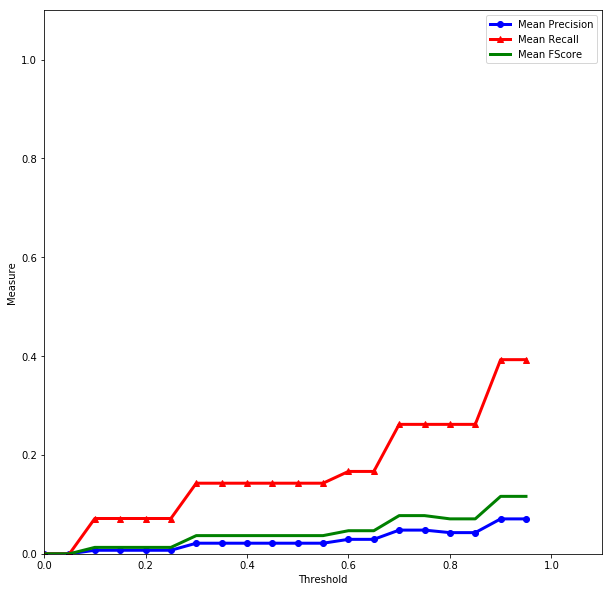

In [40]:

plt.figure(figsize=(10,10))

plt.plot(evaluations_df.threshold, evaluations_df.mean_precision, 'bo', linewidth=3.0, linestyle='-', label='Mean Precision')
plt.plot(evaluations_df.threshold, evaluations_df.mean_recall, 'r^', linewidth=3.0, linestyle='-', label='Mean Recall')
plt.plot(evaluations_df.threshold, evaluations_df.mean_fscore, 'g--', linewidth=3.0, linestyle='-', label='Mean FScore')

plt.ylabel('Measure')
plt.xlabel('Threshold')

plt.ylim(0, 1.1, 0.1)
plt.xlim(0, 1.1, 0.1)

plt.legend()

plt.show()

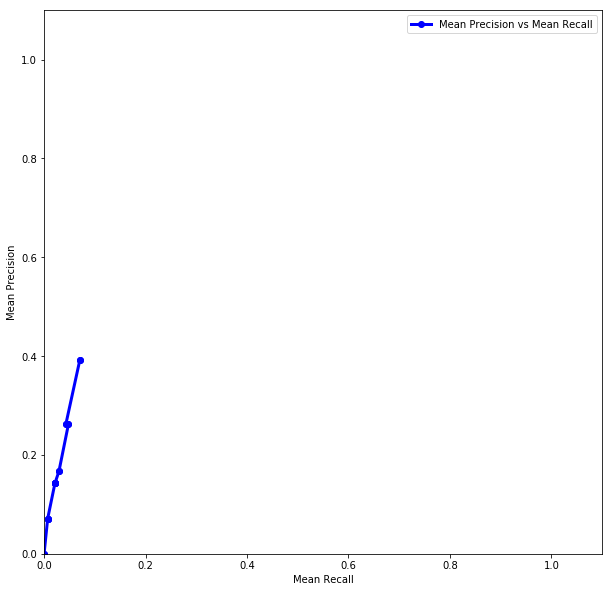

In [42]:

plt.figure(figsize=(10,10))

plt.plot(evaluations_df.mean_precision, evaluations_df.mean_recall, 'bo', linewidth=3.0, linestyle='-', label='Mean Precision vs Mean Recall')

plt.ylabel('Mean Precision')
plt.xlabel('Mean Recall')

plt.ylim(0, 1.1, 0.1)
plt.xlim(0, 1.1, 0.1)

plt.legend()

plt.show()